### The Model

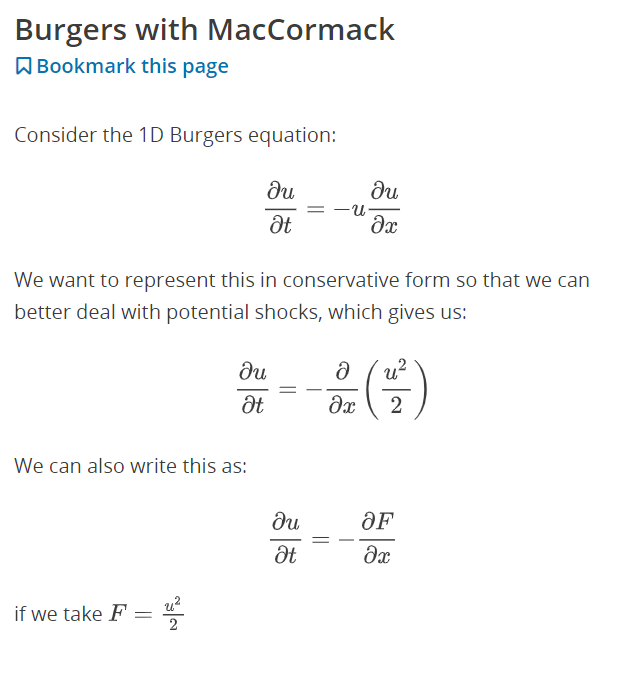


### Initial Condition: Heaviside function (step function)


$$
\begin{equation}
u(x,0) = \left\{
\begin{array}{cc}
1 & 0 \leq x < 2  \\
0 & 2 \leq x \leq 4 \\
\end{array}
\right.
\end{equation}
$$


In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def u_initial(x):
    
    u = numpy.ones_like(x)
    mask = numpy.where(x >= 2.0)
    u[mask] = 0
    return u

In [4]:
# Set parameters.
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 70  # number of time steps to compute
#rho_max = 10.0  # maximum taffic density allowed
#u_max = 1.0  # maximum speed traffic

# Get the road locations.
x = numpy.linspace(0.0, L, num=nx)

# Compute the initial traffic density.
u = u_initial(x)
print(numpy.shape(u))

(81,)


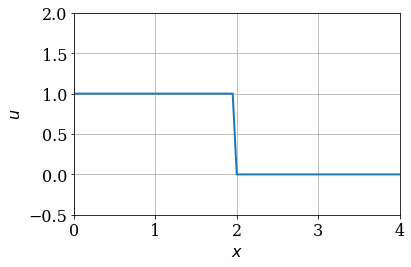

In [5]:
# Plot the initial traffic density.
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$u$')
pyplot.grid()
line = pyplot.plot(x, u,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(-0.5, 2.0)
pyplot.tight_layout()

In [6]:
def computeF(u):

    F = 0.5*(u**2)
    return F

In [7]:
from matplotlib import animation
from IPython.display import HTML

In [8]:
def update_plot(n, u_hist):
    """
    Update the line y-data of the Matplotlib figure.
    
    Parameters
    ----------
    n : integer
        The time-step index.
    rho_hist : list of numpy.ndarray objects
        The history of the numerical solution.
    """
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(u_hist[n])

In [9]:
def dt_generator(sigma, dx):

    dt = sigma*dx
    
    return dt

## MacCormack Scheme (1971)

The MacCormack scheme is a two-step method, in which the first step is called a _predictor_ and the second step is called a _corrector_. It achieves second-order accuracy in both space and time. One version is as follows:  

$$
\begin{equation}
\rho^*_i = \rho^n_i - \frac{\Delta t}{\Delta x} (F^n_{i+1}-F^n_{i}) \ \ \ \ \ \ \text{(predictor with fwd spatial diff)}
\end{equation}
$$

$$
\begin{equation}
\rho^{n+1}_i = \frac{1}{2} (\rho^n_i + \rho^*_i - \frac{\Delta t}{\Delta x} (F^*_i - F^{*}_{i-1})) \ \ \ \ \ \ \text{(corrector with backward spatial diff)}
\end{equation}
$$


In [16]:
un = numpy.zeros((nt, len(u)))
#print(un, numpy.shape(un))
un[:] = u.copy()
#print(un, numpy.shape(un))
u_star = u.copy()
#print(numpy.shape(u_star))

In [11]:
def maccormack_damped(u, nt, dt, dx, epsilon):
    
    un = numpy.zeros((nt, len(u))) #(70,81)
    un[:] = u.copy() #(70, 81)
    u_star = u.copy() #(1, 81)
    for n in range(1,nt): #(70)
        # Compute the flux.
        F = computeF(u) #(1, 81)
        
        # Predictor step of the MacCormack scheme.
        u_star[1:-1] = (u[1:-1] - dt / dx * (F[2:] - F[1:-1]) + epsilon*(u[2:] - 2*u[1:-1] + u[:-2]))
        
        # Compute the flux.
        F_star = computeF(u_star) #(1, 81)
        
        # Corrector step of the MacCormack scheme.
        un[n][1:-1] = 0.5 * (u[1:-1] + u_star[1:-1] - dt / dx * (F_star[1:-1] - F_star[:-2]))
        
        
        # Set the value at the first location.
        #u[0] = bc_values[0]
        # Set the value at the last location.
        #u[-1] = bc_values[1]
        # Record the time-step solution.
        u = un[n].copy()
    return un

In [12]:
# we try to change the epsilon, damping coefficient of the maccormack step and see its effect. Find the sweetspot
dt_1 = dt_generator(0.5, dx)

un_1 = maccormack_damped(u, nt, dt_1, dx, 0.0) #no damping
un_2 = maccormack_damped(u, nt, dt_1, dx, 0.4) #damping

In [13]:
# Create an animation of the traffic density (no damping).
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(un_1,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())

In [14]:
# Create an animation of the traffic density (with damping).
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(un_2,),
                               interval=100)
# Display the video.
HTML(anim.to_html5_video())